# Slime Mold Algorithm applied to a traveling salesman problem
The data contains more than thousand frituren located in Flanders, parsed from Google Maps via Phantom Buster. We will attempt to solve the problem of visiting all documented in the shortest amount in time.

Let us first load the data.

In [58]:
import pandas as pd
import glob
import pickle

# Get a list of all the csv files
all_files = glob.glob("data/*.csv")

# Initialize an empty list that will be filled with each file's DataFrame
all_dfs = []

# Loop over the list of files and read each one into a DataFrame
for file in all_files:
    df = pd.read_csv(file)
    all_dfs.append(df)

# Concatenate all the dataframes in the list into a single DataFrame
df = pd.concat(all_dfs, ignore_index=True)
df = df.drop_duplicates()
df = df[df['latitude'].notna() & df['longitude'].notna()]
df.to_csv("allfrituren.csv")

In [59]:
df

,placeUrl,title,rating,reviewCount,category,attributes,address,plusCode,website,phoneNumber,...,saturday,sunday,currentStatus,imgUrl,isClaimed,latitude,longitude,query,timestamp,info
0,https://www.google.com/maps/place/Frituur+%27t...,Frituur 't Koxke,4.4,114.0,Frituur,· Dine-in · Takeaway · Delivery,"'s-Herenstraat 25, 2140 Antwerpen, Belgium","6C6P+Q7 Antwerp, Belgium",https://m.facebook.com/pages/category/Restaura...,NaN,...,4 PM–12 AM,4 PM–12 AM,Closed,https://lh5.googleusercontent.com/p/AF1QipNzOf...,True,51.211937,4.435688,https://www.google.com/maps/search/frituur/@51...,2023-06-19T13:35:21.507Z,NaN
1,https://www.google.com/maps/place/Frituur+%27t...,Frituur 't hoekske,4.1,74.0,Frituur,· Dine-in · Takeaway,"Sterlingerstraat 2, 2140 Antwerpen, Belgium","6C6M+CM Antwerp, Belgium",http://www.frituurthoekskeborgerhout.be/,+32 493 43 19 00,...,5 PM–2 AM,5–10 PM,Closed,https://lh5.googleusercontent.com/p/AF1QipMamg...,True,51.211062,4.434187,https://www.google.com/maps/search/frituur/@51...,2023-06-19T13:35:28.825Z,NaN
2,https://www.google.com/maps/place/Friturist/da...,Friturist,4.0,77.0,Frituur,· Dine-in · Takeaway · Delivery,"Passendalestraat 2, 2600 Antwerpen, Belgium","5CWV+3V Antwerp, Belgium",https://www.openingsurengids.be/de-friturist/a...,+32 485 61 05 51,...,4:30–10 PM,4:30–10 PM,Open now,https://lh5.googleusercontent.com/p/AF1QipMRV-...,True,51.195187,4.444688,https://www.google.com/maps/search/frituur/@51...,2023-06-19T13:35:35.516Z,NaN
3,https://www.google.com/maps/place/Frituur+Rich...,Frituur Richard,4.1,84.0,Frituur,NaN,"Helmstraat 119, 2140 Antwerpen, Belgium","6C9P+6F Antwerp, Belgium",http://www.frituur-richard.be/,+32 3 235 31 98,...,4:30–10 PM,4:30–10 PM,Closed,https://lh5.googleusercontent.com/p/AF1QipPDYX...,False,51.218062,4.436188,https://www.google.com/maps/search/frituur/@51...,2023-06-19T13:35:43.069Z,NaN
4,https://www.google.com/maps/place/Frituur+den+...,Frituur den Hoek af,4.3,51.0,Frituur,· Dine-in · Takeaway · Delivery,"Troonplaats 11, 2018 Antwerpen, Belgium","693R+FP Antwerp, Belgium",https://frituur-den-hoek-af.unipage.eu/,+32 467 87 63 31,...,5–11:30 PM,5–11:30 PM,Closed today,https://lh5.googleusercontent.com/p/AF1QipNoJT...,True,51.203687,4.391812,https://www.google.com/maps/search/frituur/@51...,2023-06-19T13:35:53.517Z,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,https://www.google.com/maps/place/Frituur+-+Ee...,Frituur - Eethuis EnRoute,4.1,688.0,Frituur,· Dine-in · Takeaway · No-contact delivery,"Roeselaarsestraat 9a, 8850 Ardooie, Belgium","X5CV+HC Ardooie, Belgium",http://www.eethuis-enroute.be/,+32 51 70 03 56,...,"11:30 AM–2 PM, 5:30–10 PM",11:30 AM–9 PM,Closed,https://lh5.googleusercontent.com/p/AF1QipOKGG...,True,50.971437,3.193562,https://www.google.com/maps/search/frituur/@50...,2023-06-19T14:35:27.693Z,NaN
1416,https://www.google.com/maps/place/Frituur+Drie...,Frituur Driemasten Bvba,NaN,NaN,Frituur,NaN,"Klijtstraat 8, 8560 Wevelgem, Belgium","V53R+V7 Wevelgem, Belgium",NaN,+32 56 42 32 00,...,NaN,NaN,NaN,https://streetviewpixels-pa.googleapis.com/v1/...,False,50.854687,3.190688,https://www.google.com/maps/search/frituur/@50...,2023-06-19T14:35:33.001Z,NaN
1417,https://www.google.com/maps/place/Frituur+Drie...,Frituur Driemasten,4.4,106.0,Frituur,· Dine-in · Takeaway · Delivery,"Driemasten 15/Z, 8560 Wevelgem, Belgium","R5XX+77 Wevelgem, Belgium",NaN,+32 56 40 06 82,...,11 AM–2 PM,"11 AM–2 PM, 5–10 PM",Closed today,https://lh5.googleusercontent.com/p/AF1QipMsbk...,False,50.848188,3.198188,https://www.google.com/maps/search/frituur/@50...,2023-06-19T14:35:39.537Z,NaN
1418,https://www.google.com/maps/place/Frituur+Vosk...,Frituur Voske Ardooie,4.7,41.0,Frituur,· Dine-in · Takeaway · Delivery,"Stationsstraat 75, 8850 Ardooie, Belgium","X6J2+P6 Ardooie, Belgium",http://www.frituurvoske.be/,+32 478 36 91 12,...,"11:30 AM–1:30 PM, 5:30–10 PM","11:30 AM–1:30 PM, 5:30–10 PM",Closed today,https://lh5.googleusercontent.com/p/AF1QipN

In [60]:
df.columns

Index(['placeUrl', 'title', 'rating', 'reviewCount', 'category', 'attributes',
       'address', 'plusCode', 'website', 'phoneNumber', 'monday', 'tuesday',
       'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
       'currentStatus', 'imgUrl', 'isClaimed', 'latitude', 'longitude',
       'query', 'timestamp', 'info'],
      dtype='object')

In [61]:
# Extract the coordinates
coordinates = df[['latitude', 'longitude']].values
coordinates

array([[51.2119375,  4.4356875],
       [51.2110625,  4.4341875],
       [51.1951875,  4.4446875],
       ...,
       [50.8481875,  3.1981875],
       [50.9818125,  3.2005625],
       [50.9074375,  3.2018125]])

Here we load the Root and OriginalSMA classes we used in SMA.ipynb because we will built upon some of their functions.

In [62]:
import numpy as np
from numpy import where, clip, logical_and, ones, array, ceil
from numpy.random import uniform
from copy import deepcopy
from matplotlib.animation import FuncAnimation
from IPython.display import Image
import matplotlib.pyplot as plt
from numpy import sum, pi, exp, sqrt, cos, ones
from numpy.random import uniform, choice
from numpy import abs, zeros, log10, where, arctanh, tanh
from math import ceil
from scipy.spatial import distance_matrix
class Root:
    """
    This is the root of all implemented Slime Mold Algorithms. It serves as a base class providing necessary
    utility methods and attributes used in all child algorithm classes.
    """

    ID_MIN_PROB = 0  # Indicator of minimization problem
    ID_MAX_PROB = -1  # Indicator of maximization problem

    ID_POS = 0  # Indicator for Position
    ID_FIT = 1  # Indicator for Fitness

    EPSILON = 10E-10  # Small constant value to avoid division by zero

    def __init__(self, obj_func=None, lb=None, ub=None, problem_size=50, verbose=True):
        """
        Parameters
        ----------
        obj_func : function
            Objective function to be optimized
        lb : list
            Lower bounds of the search space
        ub : list
            Upper bounds of the search space
        problem_size : int, optional
            Number of decision variables
        verbose : bool, optional
            Whether to print progress of the algorithm
        """
        self.obj_func = obj_func

        # Initialization of lower and upper bounds
        if (lb is None) or (ub is None):
            if problem_size is None:
                print("Problem size must be an integer number")
                exit(0)
            elif problem_size <= 0:
                print("Problem size must be > 0")
                exit(0)
            else:
                self.problem_size = int(ceil(problem_size))
                self.lb = -1 * ones(problem_size)
                self.ub = 1 * ones(problem_size)
        else:
            # Validation of lower and upper bounds
            if isinstance(lb, list) and isinstance(ub, list) and not (problem_size is None):
                if (len(lb) == len(ub)) and (problem_size > 0):
                    if len(lb) == 1:
                        self.problem_size = problem_size
                        self.lb = lb[0] * ones(problem_size)
                        self.ub = ub[0] * ones(problem_size)
                    else:
                        self.problem_size = len(lb)
                        self.lb = array(lb)
                        self.ub = array(ub)
                else:
                    print("Lower bound and Upper bound need to be the same length. Problem size must be > 0")
                    exit(0)
            else:
                print("Lower bound and Upper bound need to be a list. Problem size is an integer number")
                exit(0)

        self.verbose = verbose
        self.epoch, self.pop_size = None, None  # Initialize epoch and population size to None
        self.solution, self.loss_train = None, []  # Initialize solution and training loss to None and empty list

    def create_solution(self, minmax=0):
        """
        Return the solution with 2 elements: position of solution and fitness of solution
        Parameters
        ----------
        minmax: int
            0 - minimization problem, else - maximization problem
        """
        position = uniform(self.lb, self.ub)  # Generate a random position within the bounds
        fitness = self.get_fitness_position(position=position, minmax=minmax)  # Get the fitness of the position
        return [position, fitness]

    def get_fitness_position(self, position=None, minmax=0):
        """
        Assumption that objective function always return the original value
        Parameters
        ----------
        position: 1-D numpy array
            Position in the search space
        minmax: int
            0 - minimization problem, 1 - maximization problem
        Returns
        -------
        Fitness of the given position
        """
        return self.obj_func(position) if minmax == 0 else 1.0 / (self.obj_func(position) + self.EPSILON)

    def get_sorted_pop_and_global_best_solution(self, pop=None, id_fit=None, id_best=None):
        """
        Sort population and return the sorted population and the best solution
        Parameters
        ----------
        pop: list
            Population list
        id_fit: int
            Identifier for fitness
        id_best: int
            Identifier for best solution
        Returns
        -------
        Sorted population list and best solution
        """
        sorted_pop = sorted(pop, key=lambda temp: temp[id_fit])  # Sort population based on fitness
        return sorted_pop, deepcopy(sorted_pop[id_best])  # Return sorted population and best solution

    def amend_position(self, position=None):
        """
        Clip position so that it remains within the defined bounds
        Parameters
        ----------
        position: numpy array
            Position to be clipped
        Returns
        -------
        Clipped position
        """
        return clip(position, self.lb, self.ub)  # Clip position with respect to lower and upper bounds

    def amend_position_random(self, position=None):
        """
        Amend the position randomly if it is out of bounds
        Parameters
        ----------
        position: numpy array
            Position to be amended
        Returns
        -------
        Amended position
        """
        return where(logical_and(self.lb <= position, position <= self.ub), position, uniform(self.lb, self.ub))

    def update_sorted_population_and_global_best_solution(self, pop=None, id_best=None, g_best=None):
        """
        Sort the population and update the current best solution.
        Return the sorted population and the new current best solution
        Parameters
        ----------
        pop: list
            Population list
        id_best: int
            Identifier for best solution
        g_best: list
            Current best solution
        Returns
        -------
        Sorted population list and updated best solution
        """
        sorted_pop = sorted(pop, key=lambda temp: temp[self.ID_FIT])  # Sort population based on fitness
        current_best = sorted_pop[id_best]  # Get the current best solution from sorted population
        # Update the global best solution if current best solution is better
        g_best = deepcopy(current_best) if current_best[self.ID_FIT] < g_best[self.ID_FIT] else deepcopy(g_best)
        return sorted_pop, g_best  # Return sorted population and updated global best solution
class OriginalSMA(Root):
    """
    Original version of Slime Mould Algorithm (SMA)
    """
    ID_WEI = 2  # Index of the 'weight' component of a solution in the population

    def __init__(self, obj_func=None, lb=None, ub=None, problem_size=50, verbose=True, epoch=750, pop_size=100, z=0.03, improvement_threshold=1e-10, max_stagnant_iterations=50):
        """
        Initialize OriginalSMA
        """
        # Initialize root with objective function, lower bound, upper bound, problem size, and verbosity level
        Root.__init__(self, obj_func, lb, ub, problem_size, verbose)
        self.epoch = epoch  # Number of training iterations
        self.pop_size = pop_size  # Population size
        self.z = z  # Parameter used in position update
        self.improvement_threshold = improvement_threshold  # Fitness improvement threshold
        self.max_stagnant_iterations = max_stagnant_iterations  # Maximum number of stagnant iterations


    def create_solution(self, minmax=0):
        """
        Create a new solution
        """
        pos = uniform(self.lb, self.ub)  # Generate a random position within the bounds
        fit = self.get_fitness_position(pos)  # Get fitness of the position
        weight = zeros(self.problem_size)  # Initialize weight vector to zero
        return [pos, fit, weight]  # Solution is a combination of position, fitness, and weight

    def train(self):
        """
        Train using SMA
        """
        # Create initial population
        pop = [self.create_solution() for _ in range(self.pop_size)]
        # Sort the population and get the global best solution
        pop, g_best = self.get_sorted_pop_and_global_best_solution(pop, self.ID_FIT, self.ID_MIN_PROB)  # Eq.(2.6)
        stagnant_iterations = 0
        optimal_positions = []

        for epoch in range(self.epoch):
            # Store old best fitness for convergence check
            old_best_fit = g_best[self.ID_FIT]
            s = pop[0][self.ID_FIT] - pop[-1][self.ID_FIT] + self.EPSILON  # Compute 's' parameter

            # Calculate the fitness weight of each slime mould
            for i in range(0, self.pop_size):
                # Eq.(2.5)
                if i <= int(self.pop_size / 2):
                    # First half of population gets increased weight
                    pop[i][self.ID_WEI] = 1 + uniform(0, 1, self.problem_size) * log10((pop[0][self.ID_FIT] - pop[i][self.ID_FIT]) / s + 1)
                else:
                    # Second half of population gets decreased weight
                    pop[i][self.ID_WEI] = 1 - uniform(0, 1, self.problem_size) * log10((pop[0][self.ID_FIT] - pop[i][self.ID_FIT]) / s + 1)

            # Compute 'a' and 'b' parameters for position update
            a = arctanh(-((epoch + 1) / self.epoch) + 1)  # Eq.(2.4)
            b = 1 - (epoch + 1) / self.epoch

            # Update the Position of search agents
            for i in range(0, self.pop_size):
                if uniform() < self.z:  # Eq.(2.7)
                    # Generate a completely new random position within bounds
                    pop[i][self.ID_POS] = uniform(self.lb, self.ub)
                else:
                    # Update position based on current fitness and positions of other individuals
                    p = tanh(abs(pop[i][self.ID_FIT] - g_best[self.ID_FIT]))  # Eq.(2.2)
                    vb = uniform(-a, a, self.problem_size)  # Eq.(2.3)
                    vc = uniform(-b, b, self.problem_size)   
                    for j in range(0, self.problem_size): 
                        # Two random individuals selected from population
                        id_a, id_b = choice(list(set(range(0, self.pop_size)) - {i}), 2, replace=False)
                        if uniform() < p:  # Eq.(2.1)
                            # Update position based on best position and positions of two other individuals
                            pop[i][self.ID_POS][j] = g_best[self.ID_POS][j] + vb[j] * (pop[i][self.ID_WEI][j] * pop[id_a][self.ID_POS][j] - pop[id_b][self.ID_POS][j])
                        else:
                            # Update position based on current position
                            pop[i][self.ID_POS][j] = vc[j] * pop[i][self.ID_POS][j]

            # Check the bounds and calculate the fitness for each individual after all position updates are done
            for i in range(0, self.pop_size):
                pos_new = self.amend_position(pop[i][self.ID_POS])  # Check bounds of the new position
                fit_new = self.get_fitness_position(pos_new)  # Calculate fitness of the new position
                pop[i][self.ID_POS] = pos_new  # Update the position in the population
                pop[i][self.ID_FIT] = fit_new  # Update the fitness in the population

            # Sort the population and update the global best solution
            pop, g_best = self.update_sorted_population_and_global_best_solution(pop, self.ID_MIN_PROB, g_best)
            self.loss_train.append(g_best[self.ID_FIT])  # Append loss of global best solution
            if self.verbose:
                print("> Epoch: {}, Best fit: {}".format(epoch + 1, g_best[self.ID_FIT]))

            fitness_improvement = abs(old_best_fit - g_best[self.ID_FIT])
            if fitness_improvement < self.improvement_threshold:
                stagnant_iterations += 1  # Increase stagnant counter
                if stagnant_iterations >= self.max_stagnant_iterations:
                    print(f"Convergence achieved at iteration {epoch + 1}. Training stopped.")
                    break  # Stop training if stagnant for too long
            else:
                stagnant_iterations = 0  # Reset stagnant counter if significant improvement

            optimal_positions_this_epoch = [self.amend_position(slime[self.ID_POS]) for slime in pop]
            optimal_positions.append(optimal_positions_this_epoch)

        self.solution = g_best  # Update the best solution found
        return g_best[self.ID_POS], g_best[self.ID_FIT], self.loss_train, optimal_positions


Some plotting functions

In [63]:
def plot_cities(ax, coordinates, color="blue"):
    """
    Plots the cities on a given axis.

    Inputs:
        - ax : the ax to plot on
        - coordinates : the coordinates of the cities
        - color : color of the cities (default blue)
    """
    p = ax.scatter(coordinates[:,1], coordinates[:,0], color=color, s=5, zorder=2)
    ax.set_aspect('equal')
    return p

def plot_tour(ax, tour, coordinates, best_fit, color="red", title=True):
    """
    Draws a tour on a given axis.

    Inputs:
        - ax : the ax to plot on
        - tour : a tour a list of indices
        - coordinates : the coordinates of the cities
        - distances : the matrix with distances
        - color : color of the tour (default red)
        - title : boolean, plot the title with cost?
    """
    for i, j in zip(tour[1:], tour[:-1]):
         xi, yi = coordinates[i,:]
         xj, yj = coordinates[j,:]
         ax.plot([yi, yj], [xi, xj], color=color, zorder=1)  # Swap x and y
            
    i, j = tour[-1], tour[0]
    xi, yi = coordinates[i,:]
    xj, yj = coordinates[j,:]

    p = ax.plot([yi, yj], [xi, xj], color=color, zorder=1)  # Swap x and y
       
    if title:
        ax.set_title('Tour of cost '+str(best_fit))
    
    return p


## First attempt at converting the SMA into a TSP solver
As the discussed SMA only optimizes mathematical functions in a continuous space, it cannot directly solve discrete problems. Thus, we attempt to rewrite the algorithm so that it could solve our TSP problem. We will document our progress and reasoning in applying the principles of the original SMA to create an algorithm that solves TSP-related problems.

## Slime mold TSP, attemp no. 1 (naive)
With our first attempt, we focussed more on transfering 
ideas from the original slime mold algorithm to a slime mold TSP implementation than on adapting the slime mold to get an optimal TSP solver.
In the original algorithm there are three main rules that can update the possition of the individuals in the 'population'.
We briefly describe these rules and how they are adjusted in our first slime mold TSP.  

*1. Finding Food:*

The finding food rule is a fully aimed at enhancing the exploration capabilities of the slime mold. In the original implementation, there is a probability equal to the parameter Z that an individual does a random update of its position within the search space. 

$\overrightarrow{X(t+1)} = rand(UB-LB) + LB$

With UB and LB denoting the upper and lower limits for the search parameters respectively. In our first slime mold TSP algorithm, we implemented this rule by making a new random permutation whenever this rule is used. The finding food rule is activated whenever a random number between 0 and 1 is smaller than the user defined z. In all other cases one of the other 2 rules (either approaching food or wrapping food) is chosen. 

Whenever the finding food option is not chosen, $r < p$ is used to choose between the Approaching Food and Wrapping Food rules. Here, r is a value between [0,1], and p is calculated using the following formula:

$p = tanh|S(i) - DF|$

With S(i) standing for the fitness of the individual, and DF denoting the fitness of the best current individual. The approaching food rule is chosen whenever $r < p$ and in all other cases the wrapping food rule in chosen. The probability that $r < p$ becomes bigger when p becomes bigger. p itself is bigger when the difference between the optimal fitness and the fitness of the current individual increases. This means that the approaching food rule is more likely to be chosen when the current individuals fitness is far off the current optimal fittness. This makes sense, as it means that individuals with a worse overall fitness are more likely to be updated to the position of the current best individual.




*2. Approaching Food:*

In contrast to the finding food rule, this rule is aimed at exploitation. In the original implementation the current individual's position is update along the current search coordinate with the following formula:

$\overrightarrow{X(t+1)} = \overrightarrow{X_b(t)} +\overrightarrow{vb}(W \times \overrightarrow{X_A(t)} -\overrightarrow{X_B(t)})$

In this case, $\overrightarrow{X_b}$ represents the location of the individual possessing the best fitness score, while $\overrightarrow{X_A}$ and $\overrightarrow{X_B}$ are randomly selected individuals from the population. W signifies the weight of the slime mold, and $\overrightarrow{vb}$ is an oscillating function (described further below). W is computed using the following equation:

$\overrightarrow{W}=
\begin{cases}
1 + r \times log\left(\dfrac{bF-S(i)}{bF-wF} +1\right) & \quad \text{Half of population with best Fitness}\\ 
1 - r \times log\left(\dfrac{bF-S(i)}{bF-wF} +1\right) & \quad \text{Other}
\end{cases}$

Here, bF and wF stand for the best and worst fitness of the current generation, S(i) denotes the fitness of the current individual, r is a random number between 0 and 1. Finally, the vb parameter is a type of oscilation parameter. It is a random number of the following interval.

$\overrightarrow{vb} = \left[-arctanh(-\left(\dfrac{t}{max_t}\right) + 1), arctanh(-\left(\dfrac{t}{max_t}\right) + 1)\right]$

where t equals the current epoch and $max_t$ the total number of epochs. 

In our naive TSP slime mold we adapted the approaching food rule by using the ```swap_segment``` function. For each individual, we performed a random swap with the current best individual. We set the size of the swap length by a given fixed number that we multiplied by the absolute value of the vb parameter. As such, the hope was that the individuals in the population could learn from the current best one. We also considered swapping segments of 2 randomly selected individuals A and B with the current individual for which the swap sizes would be determined by the weights of the randomly selected individuals. In the end we decided not to do this because it introduces to much randomness.  


*3. Wrapping food:*

In the original implementation, the wrapping food rule modifies the current individual by multiplying its position along the current search coordinate with the vc oscilator. 

$\overrightarrow{X(t+1)} = \overrightarrow{vc} \times \overrightarrow{X(t)}$

where vc is a random number in the interval:

$\overrightarrow{vc} = \left[-(1-\left(\dfrac{t}{max_t}\right)), 1-\left(\dfrac{t}{max_t}\right)\right]$

To adjust such a self-modfication rule in the naive slime mold TSP, we implemented a random city swap by using the ```elementary_random_swap``` function from the course as the wrapping food rule.

In [57]:
class TSPSMA(OriginalSMA):
    def __init__(self, obj_func=None, cities=None, verbose=True, epoch=1500, pop_size=100, z=0.03, tolerance = 1e-16, max_epochs_without_improvement = 30):
        self.cities = cities  # List of city coordinates
        self.dist_matrix = np.array([[haversine(lon1, lat1, lon2, lat2) for lon2, lat2 in cities] for lon1, lat1 in cities])  # Calculate distance matrix
        problem_size = len(cities)  # Total number of cities
        super().__init__(obj_func, None, None, problem_size, verbose, epoch, pop_size, z)  # Inherit original SMA attributes
        self.tolerance = tolerance  # Minimum significant fitness improvement
        self.max_epochs_without_improvement = max_epochs_without_improvement  # Maximum number of epochs without significant improvement

    def create_solution(self, minmax=0):
        pos = np.random.permutation(self.problem_size)  # Generate a random permutation
        fit = self.get_fitness_position(pos)  # Calculate the total distance
        return [pos, fit]  # Each solution consists of a position, fitness and weight

    def get_fitness_position(self, position=None, minmax=0):
        total_distance = np.sum([self.dist_matrix[position[i]][position[(i+1) % self.problem_size]] for i in range(self.problem_size)])  # Calculate total distance of the tour
        return total_distance

    def train(self):
        best_fitness = float('inf') 
        epochs_without_improvement = 0
        pop = [self.create_solution() for _ in range(self.pop_size)]  # Initialize population
        pop, g_best = self.get_sorted_pop_and_global_best_solution(pop, self.ID_FIT, self.ID_MIN_PROB)  # Sort population and get best global solution
        keeper = []
        for epoch in range(self.epoch):  # Start training over multiple epochs
            a = arctanh(-((epoch + 1) / self.epoch) + 1)
            
            for i in range(0, self.pop_size):
                if uniform() < self.z:  # Introduce random new individual based on given probability z
                    pop[i][self.ID_POS] = np.random.permutation(self.problem_size) 
                else:
                    p = tanh(abs(pop[i][self.ID_FIT] - g_best[self.ID_FIT]))                
                    vb = uniform(0, a)
                    if uniform() < p:  # If p is smaller than random number, swap segments between best and current tour...
                        segment_length_best = int(ceil(vb * 5))
                        pop[i][self.ID_POS] = swap_segment(tour1= list(g_best[self.ID_POS]), tour2=list(pop[i][self.ID_POS]), segment_length=segment_length_best)
                    else:  # If p is larger, replace current tour with a random tour
                        pop[i][self.ID_POS] = elementary_random_swap(list(pop[i][self.ID_POS]))

            for i in range(0, self.pop_size):  # Update fitness of the individuals after position updates
                fit_new = self.get_fitness_position(pop[i][self.ID_POS])  
                pop[i][self.ID_FIT] = fit_new  

            # Update population and global best solution after fitness update
            pop, g_best = self.update_sorted_population_and_global_best_solution(pop, self.ID_MIN_PROB, g_best)
            self.loss_train.append(g_best[self.ID_FIT])  # Append loss of global best solution

            # Check for convergence
            if abs(best_fitness - g_best[self.ID_FIT]) > self.tolerance:  # If there is a significant improvement, update best_fitness and reset epochs_without_improvement
                best_fitness = g_best[self.ID_FIT]
                epochs_without_improvement = 0
            else:  # If not, increase epochs_without_improvement
                epochs_without_improvement += 1

            keeper.append([g_best[self.ID_POS],g_best[self.ID_FIT]])

            # Stop training if there are too many epochs without significant improvement
            if epochs_without_improvement >= self.max_epochs_without_improvement:
                print("Convergence reached after {} epochs.".format(epoch))
                break
            
        self.solution = g_best  # Update the best solution found
        return g_best[self.ID_POS], g_best[self.ID_FIT], self.loss_train, keeper  # Return the best tour, its fitness, the training losses and the keeper

### Helper fucntions
The random segment swap operation is a technique often employed in genetic algorithms for tour exploration. The procedure consists of swapping a randomly chosen segment from one tour (`tour1`) with an equivalent-sized segment in another tour (`tour2`).

The `swap_segment` function handles this process. It initiates by verifying if the lengths of `tour1` and `tour2` are the same. Then, a segment from `tour1` is randomly chosen and subsequently replaces a randomly selected segment in `tour2`. Following the swap, the updated `tour2` might include duplicate cities and omit certain ones. 

To rectify this, the `replace_duplicates_outside_segment` function is invoked. It identifies the cities within the inserted segment, the positions of any duplicate cities outside of this segment, and the cities missing from the updated `tour2`. It then substitutes each extraneous city outside the inserted segment with a missing city from the original tour. If there are more duplicates than missing cities, it eliminates the excess duplicates.

These operations aim to uphold the integrity of the tours, ensuring each city appears exactly once, thereby generating a valid and diverse set of tours for further exploration in the discrete search space.

To test it, we take a small subset of the dataset (50 random frituren) and apply our algorithm to it.

In [80]:
import random
# swap part of one tour into another while keeping validity
def swap_segment(tour1, tour2, segment_length=3):
    # swap a segment of a given length of tour1 into tour 2 while keeping a valid tour...
    assert len(tour1) == len(tour2)
    tour_size = len(tour1)

    # Save copies of original tours to identify missing cities later
    original_tour2 = tour2.copy()

    # Select a random segment from tour1
    idx1 = random.randint(0, tour_size - segment_length)

    # Get the segment
    segment1 = tour1[idx1:idx1 + segment_length]

    # Add the segment to tour2 at a random position
    idx2 = random.randint(0, tour_size - segment_length)
    new_tour2 = tour2[:idx2] + segment1 + tour2[idx2 + segment_length:]
    
    
    
    # Remove duplicates not in the added segment and replace with missing cities
    new_tour2 = replace_duplicates_outside_segment(new_tour2, segment1, idx2, segment_length, original_tour2)

    return new_tour2

def replace_duplicates_outside_segment(tour, segment, start_idx, segment_length, original_tour):
    # Identify cities in segment
    segment_cities = set(segment)
    
    # Identify duplicates outside segment by their position
    duplicates = [i for i, city in enumerate(tour) if city in segment_cities and not start_idx <= i < start_idx + segment_length]
 #   print(duplicates)
    # Identify missing cities
    missing = list(set(original_tour) - set(tour))
  #  print(missing)
    # Replace duplicates with missing cities
    new_tour = tour.copy()
    for i, mis in enumerate(missing):
       # print(duplicates, len(duplicates), len(missing))
        new_tour[duplicates[i]] = missing[i]
        
    duplicates = set([d for i, d in enumerate(duplicates) if i >= len(missing)])
    new_tour = [el for i, el in enumerate(new_tour) if i not in duplicates] # remove additional duplicates.

    return new_tour

tour1 = [1, 2, 3, 5, 4, 6, 7, 8, 9,15,12,13,10,11,14]
tour2 = [9, 3, 7, 8, 2, 6, 5, 1, 4,14,12,13,11,10,15]
print("Before swapping:")
print("Tour 1:", tour1)
print("Tour 2:", tour2)

tour2 = swap_segment(tour1, tour2)

print("\nAfter swapping:")
print("Tour 2:", tour2)

Before swapping:
Tour 1: [1, 2, 3, 5, 4, 6, 7, 8, 9, 15, 12, 13, 10, 11, 14]
Tour 2: [9, 3, 7, 8, 2, 6, 5, 1, 4, 14, 12, 13, 11, 10, 15]

After swapping:
Tour 2: [9, 3, 1, 4, 2, 5, 6, 7, 8, 14, 12, 13, 11, 10, 15]


Here we define a function where a simple two-city swap is performed on a tour to create a new tour.

In [ ]:
def elementary_random_swap(tour):
    """
    This function performs an elementary random swap operation on a tour.
    It randomly selects two cities and swaps their positions in the tour.

    Input:
    - tour: A list of city indices representing the tour.

    Output:
    - new_tour: A new tour obtained by swapping two cities in the input tour.
    """
    new_tour = tour.copy()
    i,j = random.sample(tour, 2)
    new_tour[i], new_tour[j] =  tour.copy()[j] , tour.copy()[i]       # Swapping the positions of two cities in the tour
    return new_tour

This function, `haversine`, calculates the great-circle distance between two points on the Earth's surface, given their longitude and latitude coordinates. The great-circle distance is the shortest distance over the Earth's surface, which is crucial when considering real-world travel where we cannot cut through the Earth.

In [ ]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


### Test of attempt no. 1

In [74]:
# Take a random subset of the coordinates
#subset_size = 50  # Specify the size of the subset
#subset = random.sample(list(coordinates), subset_size)

# Convert the subset to a numpy array
#subset = np.array(subset)
# save so we dint have to recalculate every time
#with open('subset.pickle', 'wb') as f:
#    pickle.dump(subset, f)

with open('subset.pickle', 'rb') as f:
    subset = pickle.load(f)

Convergence reached after 128 epochs.
Best tour: [33, 1, 28, 16, 34, 43, 44, 12, 0, 40, 32, 49, 46, 15, 29, 20, 24, 3, 19, 30, 23, 7, 38, 5, 14, 31, 27, 41, 22, 10, 6, 11, 25, 4, 35, 13, 47, 39, 8, 42, 2, 9, 26, 36, 37, 18, 21, 45, 48, 17]
Total distance: 2217.589704629139


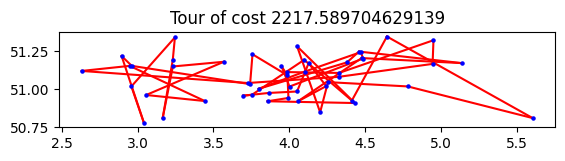

In [496]:
# Create an instance of TSPSMA with the subset
tsp_sma = TSPSMA(cities=subset, tolerance = 1e-24, max_epochs_without_improvement = 50, pop_size=200)

# Train the model
best_tour, best_fit, loss_train, keeper = tsp_sma.train()

# Print the best tour and its total distance
print("Best tour:", best_tour)
print("Total distance:", best_fit)


fig, ax = plt.subplots()
plot_cities(ax, subset)
plot_tour(ax, best_tour, subset, best_fit)
plt.show()

We can see that our resulting tour is far underoptimized.

In [75]:
def animationTSP(keeper, subset, file, interval = 200):
    def plot_tour(ax, tour, coordinates,color="red"):
        """
        Draws a tour on a given axis.

        Inputs:
            - ax : the ax to plot on
            - tour : a tour a list of indices
            - coordinates : the coordinates of the cities
            - distances : the matrix with distances
            - color : color of the tour (default red)
            - title : boolean, plot the title with cost?
        """
        for i, j in zip(tour[1:], tour[:-1]):
            xi, yi = coordinates[i,:]
            xj, yj = coordinates[j,:]
            ax.plot([yi, yj], [xi, xj], color=color, zorder=1)  # Swap x and y
                
        i, j = tour[-1], tour[0]
        xi, yi = coordinates[i,:]
        xj, yj = coordinates[j,:]

        p = ax.plot([yi, yj], [xi, xj], color=color, zorder=1)  # Swap x and y
        return p
        
    fig, (ax1, ax2) = plt.subplots(2, 1)
    opts, loss = [keeper[i][0] for i in range(len(keeper))], [keeper[i][1] for i in range(len(keeper))]
    # Set up the x and y axis limits for ax1
    plot_cities(ax1, subset)

    # Create an empty list to hold the markers
    markers = []

    # Add legend and labels to ax1
    ax1.legend()

    # Set up the x and y axis limits for ax2
    x_min, x_max = 0, len(loss) # Assuming 'loss' is your list of fitness values for each epoch
    y_min, y_max = min(loss), max(loss)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)

    # Create a line plot for fitness progression over time
    x = np.arange(len(loss))
    line2, = ax2.plot(x, loss, 'g-', label='Fitness Progression')

    # Create a marker for the current epoch in the fitness plot
    marker2, = ax2.plot([], [], 'bo', markersize=10, label='Current Epoch')

    # Add legend and labels to ax2
    ax2.legend()
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Fitness')

    # Update function for animation
    def update(frame):
            # Clear the ax1
        ax1.clear()

        # Plot the cities again
        plot_cities(ax1, subset)

        # Plot the tour with the current opt
        plot_tour(ax1, opts[frame], subset)

        # Update the position of the marker on the ax2
        marker2.set_data(frame, loss[frame])
        
        return 

    # Create the animation
    animation = FuncAnimation(fig, update, frames=len(opts), interval=interval)

    # Save the animation as a GIF
    animation.save(file, writer='imagemagick')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_28267/2945056248.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker2.set_data(frame, loss[frame])


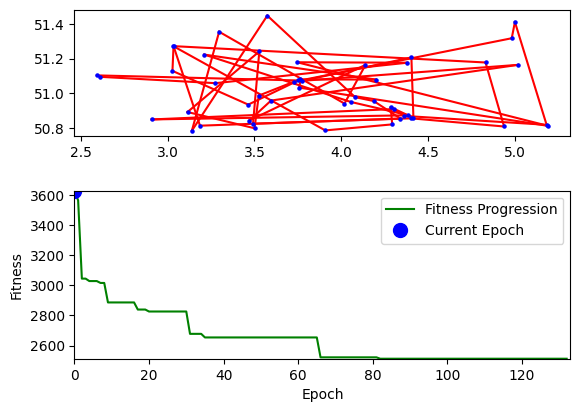

In [485]:
animationTSP(keeper, subset, 'fig/TSPSMA1.gif')

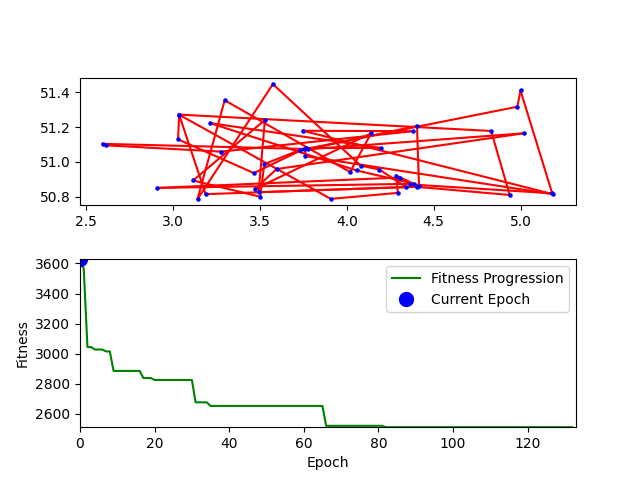

In [486]:
Image(filename='fig/TSPSMA1.gif')

### We can see that our resulting tour is far underoptimized.

There are multiple reasons why our naive slime mold could be suboptimal. 
Our first swap_segment function is not optimal. Next to swapping segment of one tour into another tour it also has to remove duplicates and insert missing values that result from the swapping procedure, which can introduce to much random variation. The same is true for the finding food rule, which introduces a new random individual in the population. This rule is great for exploring the search space, but it might again introduce to much variation to allow the algorithm to exploit the search space. Finally, the p variable was not even adjusted to the TSP objective function, as the difference between the optimal and current indivduals fittness tends to be quite big in general. Therefore we observed that the naive TSP slime mold almost never uses the wrapping food rule. Clearly, a better solution is needed.

## Slime mold TSP, attempt no. 2 (awakening from our dogmatic slumber)
We made a lot of changes in going from the first to the second implementation of the slime mold TSP.
The second implementation doesn't have the finding food mode anymore (which corresponds to randomly generating a new tour in the original implementation).
Further, we also use another less crude method to swap segments between tours (edge recombination cross-over). 
The second slime mold algorithm still has opperations to explicitly wrap and approaching food. These are also a bit different.
First, we  changed the selection criterion between the approaching and wrapping modes so that it is suited to the TSP objective function.
Originally, the approaching mode was chosen when a random number between 0 and 1 was smaller than p with p:

$p = tanh|S(i) - DF|$ (p in the naive slime mold)

Where S(i) stands for the fitness of the individual, and DF denotes the fitness of the best current individual. The problem with this function for p is that the absolute difference between S(i) and DF tends to be big in general for the TSP objective function, which sets the value of p typically to one. Therefore we used a relative difference to compute p:

$
\displaystyle p = \frac{bF-S(i)}{bF-wF+1} 
$       (p in slime molde 2.0)

Here, bF and wF stand for the best and worst fitness of the current population and S(i) again for the fitness of the current individual. Just as in the first implementation we select the approaching food mode when a random number between 0 and 1 is smaller than p.

*1. Approaching food:*

In slime mold TSP 2.0, there are 2 sub-modes that can get activated in the approaching food mode. The selection of these modes is again with a stochastic criterion. In this case it is based on a parameter q. 


$
\displaystyle q = \frac{N}{N_{max}}
$

where $N$ and $N_{max}$ respectively correspond to the total number of epochs without improvement and the maximal number of epochs without improvement (user defined). The first subcriterion is chosen when a random number between 0 and 1 is bigger than q. In this submode we use the edge recombination cross-over between the current individual and the indidvidual with the highest fitness. Which is relatively similar to the naive slime mold TSP.  
When the random number is smaller than q, the second submode is selected. We took some inspiration from the approaching food mode of the original continious SMA algorithm for this. In the original SMA the approach food mode updates the position of the current individual according to the position of the best individual, but also according to 2 randomly selected individuals. The contribution of the 2 randomly selected individuals to the position update depends on the weights of these individuals. In the original implementation these are computed by: 
 
$\overrightarrow{W}=
\begin{cases}
1 + r \times log\left(\dfrac{bF-S(i)}{bF-wF} +1\right) & \quad \text{Half of population with best Fitness}\\ 
1 - r \times log\left(\dfrac{bF-S(i)}{bF-wF} +1\right) & \quad \text{Other}
\end{cases}$ 

We changed computation of these weights by the following formula: 

$
\overrightarrow{W}=
\begin{cases}
1 + \left| \dfrac{bF-S(i)}{bF-wF+1} \right| & \quad \text{Half of population with best Fitness}\\ 
1 -  \left| \dfrac{bF-S(i)}{bF-wF+1} \right| & \quad \text{Other}
\end{cases}
$


We tweeked this formula a bit based on the weight distribution that it tended to give back. One example of this distribution is shown in the following figure:


![weight_dist](fig/weight_dist.png)

Clearly the distribution is split in 2 parts, which correspond to the half of the population with the best and worst fitness.
We used this weight distribution to select an individual in a random weighted manner when submode 2 is activated. This selected individual is then used for an edge recombination cross-over. 
We used these 2 submethods to avoid getting stuck in a local optimum. 
The rationale between the use of the two submethods in the approaching mode is to avoid getting stuck in local optima. By increasing the change that the edge recombination cross-over is chosen between a weighted randomly sampled individual and the current individual when q is big (so when the algorithm fails to improve the fittnes over multiple epochs), we try to simulate a sort of stress response in the slime mold when it fails to find better food (i.e. a lower fitness). By swapping more from the non-optimal individual the slime mold might be able to break out of a local optimum. By using weighted sampling, there is still a rationale behind this stress response. 





*2. Wrapping mode:*

In slime mold 2.0 we still do a random swap between 2 cities when the wrapping mode is activated.

In [507]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians

class TSPSMA(OriginalSMA):
    def __init__(self, obj_func=None, cities=None, verbose=True, epoch=1500, pop_size=500, tolerance=1e-16, max_epochs_without_improvement=30):
        # Initialize TSPSMA with cities and distance matrix
        self.cities = cities
        self.dist_matrix = distance_matrix(cities, cities)
        problem_size = len(cities)
        self.dist_matrix = np.array([[haversine(lon1, lat1, lon2, lat2) for lon2, lat2 in cities] for lon1, lat1 in cities])
        self.problem_size = len(cities)
        super().__init__(obj_func, None, None, problem_size, verbose, epoch, pop_size)
        self.tolerance = tolerance
        self.max_epochs_without_improvement = max_epochs_without_improvement
        self.haverdist = haversine_distances([np.radians(coord) for coord in cities])*6371.0

    def create_solution(self):
        # Create a solution for the TSP
        pos = np.random.permutation(self.problem_size)
        fit = self.get_fitness_position_km(pos)
        weight = np.zeros(self.problem_size)
        return [pos, fit, weight]

    def get_fitness_position(self, position=None):
        # Calculate the total distance for a given position
        total_distance = np.sum([self.dist_matrix[position[i]][position[(i+1)% self.problem_size]] for i in range(self.problem_size)])
        return total_distance

    def get_fitness_position_km(self, position=None):
        # Calculate the total distance in kilometers for a given position
        total_distance = np.sum([self.haverdist[position[i]][position[(i+1) % self.problem_size]] for i in range(self.problem_size)])
        return total_distance

    def train(self):
        # Train the model
        best_fitness = float('inf')
        epochs_without_improvement = 0
        pop = [self.create_solution() for _ in range(self.pop_size)]
        pop, g_best = self.get_sorted_pop_and_global_best_solution(pop, self.ID_FIT, self.ID_MIN_PROB)
        keeper = []

        for epoch in range(self.epoch):
            old_best_fit = g_best[self.ID_FIT]
            s = pop[0][self.ID_FIT] - pop[-1][self.ID_FIT] + self.EPSILON
            for i in range(self.pop_size):
                pop[i][self.ID_WEI] = abs(1 + (pop[0][self.ID_FIT] - pop[i][self.ID_FIT]) / (s + 1)) if i <= self.pop_size / 2 else abs(1 -  (pop[0][self.ID_FIT] - pop[i][self.ID_FIT]) / (s + 1))

            for i in range(self.pop_size):
                # Calculate fitness and weight distributions
                total_fit = np.sum([pop[i][self.ID_FIT] for i in range(len(pop))])
                p = abs((g_best[self.ID_FIT] - pop[i][self.ID_FIT]) / (s + 1))
                total_weight = np.sum([pop[i][self.ID_WEI] for i in range(len(pop))])
                id_a, id_b = choice(range(len(pop)), 2, replace=False)

                # Implement crossover or mutation depending on random condition
                if uniform() < p:
                    q = epochs_without_improvement / self.max_epochs_without_improvement
                    if uniform() > q:
                        parent1_edges, parent2_edges, merged_edges = find_edges(list(pop[i][self.ID_POS]), list(g_best[self.ID_POS]))
                        pop[i][self.ID_POS] = crossover(list(pop[i][self.ID_POS]), list(g_best[self.ID_POS]), merged_edges)
                    else:
                        weight_distribution = [pop[i][self.ID_WEI] for i in range(1,len(pop))]
                        pop_ids = [i for i in range(1,len(pop))]
                        id_selected = random.choices(pop_ids, weight_distribution, k=1)[0]
                        parent1_edges, parent2_edges, merged_edges = find_edges(list(pop[i][self.ID_POS]), list(pop[id_selected][self.ID_POS]))
                        pop[i][self.ID_POS] = crossover(list(pop[i][self.ID_POS]), list(pop[id_selected][self.ID_POS]), merged_edges)
                else:
                    pop[i][self.ID_POS] = elementary_random_swap(list(pop[i][self.ID_POS]))

            # Update the fitness in the population and the global best solution
            for i in range(self.pop_size):
                fit_new = self.get_fitness_position_km(pop[i][self.ID_POS])
                pop[i][self.ID_FIT] = fit_new
            pop, g_best = self.update_sorted_population_and_global_best_solution(pop, self.ID_MIN_PROB, g_best)
            self.loss_train.append(g_best[self.ID_FIT])

            # Check for convergence
            if abs(best_fitness - g_best[self.ID_FIT]) > self.tolerance:
                best_fitness = g_best[self.ID_FIT]
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            keeper.append([g_best[self.ID_POS], g_best[self.ID_FIT]])
            if self.verbose and epochs_without_improvement == 0:
                print("> Epoch: {}, Best fit: {}".format(epoch + 1, g_best[self.ID_FIT]))
                print("Best fit in kms: "+str(self.get_fitness_position_km(g_best[self.ID_POS])))

            if epochs_without_improvement >= self.max_epochs_without_improvement:
                print("Convergence reached after {} epochs.".format(epoch))
                break

        self.solution = g_best
        return g_best[self.ID_POS], g_best[self.ID_FIT], self.loss_train, keeper

### Helper function
#### Edge Recombination Crossover

Edge Recombination Crossover (ERX) is an operator designed for use with sequence representation in genetic algorirthms, such as those required for the Traveling Salesman Problem [1]. It aims to take advantage of the good edges present in the parent chromosomes. Instead of focusing on preserving the absolute position of nodes (or cities, in the TSP context), ERX focuses on preserving the edges, i.e., where the order of elements is important, such as for our case. The idea is that a good tour has good edges and by preserving these edges, it should produce a good offspring.

The process initiates by creating an adjacency list for each parent solution, which represents the neighbors for each node, defined as the entities visited immediately before or after a given node. The crossover begins with the selection of a starting node, possibly random or from a parent solution. The algorithm then selects the next node from a combined list of unique neighbors derived from both parents' adjacency lists, favoring nodes not yet included in the offspring solution and those appearing in both parents' adjacency lists. In the absence of such a node, a random selection is made. Once a node is added to the offspring's solution, it is eliminated from the adjacency lists of all other nodes to prevent duplication. This process of neighbor selection and edge removal is repeated until all nodes are included in the offspring's solution, creating a new solution that retains as much information about the parents' node relationships as possible. This makes ERX particularly suited for problems where the relationship between nodes is more significant than their exact sequence.

[1]: Whitley, Darrell; Timothy Starkweather; D'Ann Fuquay (1989). "Scheduling problems and traveling salesman: The genetic edge recombination operator". International Conference on Genetic Algorithms. pp. 133–140. ISBN 1-55860-066-3.)

In [ ]:
from itertools import groupby

#Gets edges for parent1, parent2
def find_edges(parent1, parent2):
    parent1_edges = calc_edges(parent1)
    parent2_edges = calc_edges(parent2)
    merged_edges = merge_edges(parent1_edges, parent2_edges)  

    return (parent1_edges, parent2_edges, merged_edges)

#calculates edges for an individual
def calc_edges(individual):
    edges = [] 
    for position in range(len(individual)):
        if position == 0:
            edges.append([individual[position], (individual[-1], individual[position+1])])
        elif position < len(individual)-1:
            edges.append([individual[position], (individual[position-1], individual[position+1])])
        else:
            edges.append([individual[position], (individual[position-1], individual[0])])
    return edges

# Sort the edges    
def sort_edges(individual):
    individual.sort(key=lambda x: x[0])

# Perform a union on two parents
def merge_edges(parent1, parent2):
    sort_edges(parent1)
    sort_edges(parent2)

    edges = []
    for val in range(len(parent1)):
        edges.append([parent1[val][0], union(parent1[val][1], parent2[val][1])])
    return edges

#part of merge_edges - unions 2 individual
def union(individual1, individual2):
    edges = list(individual1)

    for val in individual2:
        if val not in edges:
            edges.append(val)
    return edges


def crossover(parent1, parent2, edges):
    k = []
    previous = None
    current = random.choice([parent1[0], parent2[0]])

    while True:
        k.append(current)

        if(len(k) == len(parent1)):
            break
        previous = remove_node_from_neighbouring_list(current, edges)
        current_neighbour = get_current_neighbour(previous, edges)

        next_node = None
        if len(current_neighbour) > 0:
            next_node = get_best_neighbour(current_neighbour)
        else:
            next_node = get_next_random_neighbour(k, edges)

        current = next_node[0]
    return k
  
#returns the best possible neighbour
def get_best_neighbour(neighbour):
    if len(neighbour) == 1:
        return neighbour[0]
    else:
        group_neighbour = group_neighbours(neighbour)
        return random.choice(group_neighbour[0])[1]

#part of get_best_neighbour   
def group_neighbours(neighbours):
    sorted_neighbours = []

    #store length of each individual neighbour + neighbour in a list
    for neighbour in neighbours:
        sorted_neighbours.append((len(neighbour[1]), neighbour))

    #sort the new list
    sort_edges(sorted_neighbours)

    #group the neighbour by their size
    groups = []
    for k, g in groupby(sorted_neighbours, lambda x: x[0]):
        groups.append(list(g))

    return groups

#returns a random neighbour from remaining_edges that does not exist in current_path
def get_next_random_neighbour(current_path, remaining_edges):
    random_node = None

    while random_node is None:
        tmp_node = random.choice(remaining_edges)

        if tmp_node[0] not in current_path:
            random_node = tmp_node
  
    return random_node
    
# removes node from neighbouring list
def remove_node_from_neighbouring_list(node, neighbour_list):
    removed_node = None

    for n in neighbour_list:
        if n[0] == node:
            removed_node = n
            neighbour_list.remove(n)
    
        if node in n[1]:
            n[1].remove(node)
  
    return removed_node
    
#return neighbours for a give node(s)
def get_current_neighbour(nodes, neighbour_lists):
    neighbours = []

    if nodes is not None:
        for node in nodes[1]:
            for neighbour in neighbour_lists:
                if node == neighbour[0]:
                    neighbours.append(neighbour)

    return neighbours
# Define two parent tours
parent1 = [1, 0, 2, 3, 7, 5, 6, 4]
parent2 = [0, 2, 4, 6, 1, 3, 5, 7]

# Find edges of the parents
parent1_edges, parent2_edges, merged_edges = find_edges(parent1, parent2)

# Generate offspring through crossover
offspring = crossover(parent1, parent2, merged_edges)

print("Parent 1: ", parent1)
print("Parent 2: ", parent2)
print("Offspring: ",offspring)

> Epoch: 1, Best fit: 2188.666732354153
Best fit in kms: 2188.666732354153
> Epoch: 2, Best fit: 1901.4824138099132
Best fit in kms: 1901.4824138099132
> Epoch: 3, Best fit: 1816.376585048329
Best fit in kms: 1816.376585048329
> Epoch: 4, Best fit: 1783.079432991977
Best fit in kms: 1783.079432991977
> Epoch: 6, Best fit: 1683.9293846837113
Best fit in kms: 1683.9293846837113
> Epoch: 7, Best fit: 1655.7077908809717
Best fit in kms: 1655.7077908809717
> Epoch: 8, Best fit: 1635.721765464217
Best fit in kms: 1635.721765464217
> Epoch: 9, Best fit: 1604.6037551809109
Best fit in kms: 1604.6037551809109
> Epoch: 10, Best fit: 1582.8613308549059
Best fit in kms: 1582.8613308549059
> Epoch: 11, Best fit: 1567.7781020325056
Best fit in kms: 1567.7781020325056
> Epoch: 12, Best fit: 1498.6669890075846
Best fit in kms: 1498.6669890075846
> Epoch: 13, Best fit: 1481.261020779231
Best fit in kms: 1481.261020779231
> Epoch: 14, Best fit: 1446.9410624314598
Best fit in kms: 1446.9410624314598
> Ep

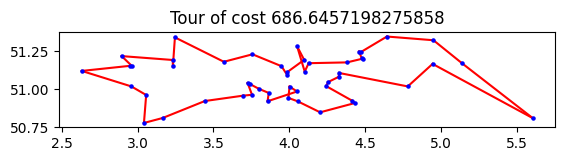

In [499]:
from itertools import groupby
# Create an instance of TSPSMA with the subset
tsp_sma = TSPSMA(cities=subset, tolerance = 1e-24, max_epochs_without_improvement = 100, pop_size = 200)

# Train the model
best_tour, best_fit, loss_train, keeper = tsp_sma.train()

# Print the best tour and its total distance
print("Best tour:", best_tour)
print("Total distance:", best_fit)


fig, ax = plt.subplots()
plot_cities(ax, subset)
plot_tour(ax, best_tour, subset, best_fit)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_28267/2471214907.py:67: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker2.set_data(frame, loss[frame])


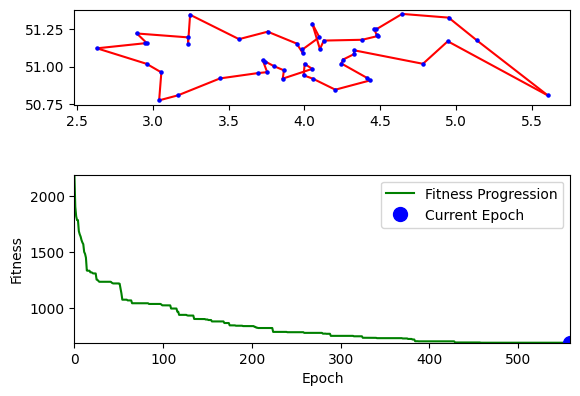

In [502]:
animationTSP(keeper, subset, 'fig/TSPSMA2.gif')

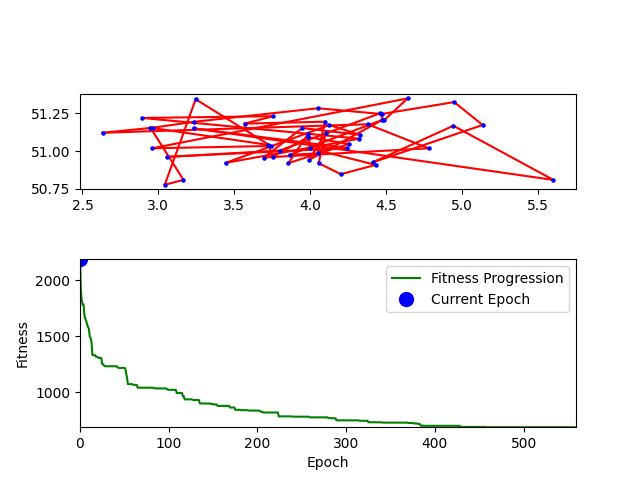

In [504]:
Image(filename='fig/TSPSMA2.gif')

### Slime mold TSP, attempt no. 3 (finalizations)
We left our 2nd attempt mainly untouched since it already had decent performance. We noticed in the resulting figures that it could not quite reach (quasi) globally optimal results yet, as it could use more small frituur-swaps. We opted to introduce more small perturbations to the better individuals. 

Now the algorithm gives a chance to better individuals to undergo an random elementary swap, decided by $p$ as in the 2nd attempt. If the swap is useful (if it lowers the cost), then this swap will be allowed. This is particularly useful for better performing individuals since a large operation, such as a recombiantion, on a good tour would mostly worsen it's fitness. With the small perturbations, we allow it to locally scour for better positions. For the more costly individuals, the chance of recombination increases according to $p$.

In [76]:
class TSPSMA(OriginalSMA):
    def __init__(self, obj_func=None, cities=None, verbose=True, epoch=1500, pop_size=500, tolerance=1e-16, max_epochs_without_improvement=30):
        # Initialize TSPSMA with cities and distance matrix
        self.cities = cities
        self.dist_matrix = distance_matrix(cities, cities)
        problem_size = len(cities)
        self.dist_matrix = np.array([[haversine(lon1, lat1, lon2, lat2) for lon2, lat2 in cities] for lon1, lat1 in cities])
        self.problem_size = len(cities)
        super().__init__(obj_func, None, None, problem_size, verbose, epoch, pop_size)
        self.tolerance = tolerance
        self.max_epochs_without_improvement = max_epochs_without_improvement
        self.haverdist = haversine_distances([np.radians(coord) for coord in cities])*6371.0

    def create_solution(self):
        # Create a solution for the TSP
        pos = np.random.permutation(self.problem_size)
        fit = self.get_fitness_position_km(pos)
        weight = np.zeros(self.problem_size)
        return [pos, fit, weight]

    def get_fitness_position(self, position=None):
        # Calculate the total distance for a given position
        total_distance = np.sum([self.dist_matrix[position[i]][position[(i+1)% self.problem_size]] for i in range(self.problem_size)])
        return total_distance

    def get_fitness_position_km(self, position=None):
        # Calculate the total distance in kilometers for a given position
        total_distance = np.sum([self.haverdist[position[i]][position[(i+1) % self.problem_size]] for i in range(self.problem_size)])
        return total_distance

    def train(self):
        # Train the model
        best_fitness = float('inf')
        epochs_without_improvement = 0
        pop = [self.create_solution() for _ in range(self.pop_size)]
        pop, g_best = self.get_sorted_pop_and_global_best_solution(pop, self.ID_FIT, self.ID_MIN_PROB)
        keeper = []

        for epoch in range(self.epoch):
            old_best_fit = g_best[self.ID_FIT]
            s = pop[0][self.ID_FIT] - pop[-1][self.ID_FIT] + self.EPSILON
            for i in range(self.pop_size):
                pop[i][self.ID_WEI] = abs(1 + (pop[0][self.ID_FIT] - pop[i][self.ID_FIT]) / (s + 1)) if i <= self.pop_size / 2 else abs(1 -  (pop[0][self.ID_FIT] - pop[i][self.ID_FIT]) / (s + 1))

            for i in range(self.pop_size):
                # Calculate fitness and weight distributions
                total_fit = np.sum([pop[i][self.ID_FIT] for i in range(len(pop))])
                p = abs((g_best[self.ID_FIT] - pop[i][self.ID_FIT]) / (s + 1))
                total_weight = np.sum([pop[i][self.ID_WEI] for i in range(len(pop))])
                id_a, id_b = choice(range(len(pop)), 2, replace=False)

                # Implement crossover or mutation depending on random condition
                if uniform() < p:
                    q = epochs_without_improvement / self.max_epochs_without_improvement
                    if uniform() > q:
                        parent1_edges, parent2_edges, merged_edges = find_edges(list(pop[i][self.ID_POS]), list(g_best[self.ID_POS]))
                        pop[i][self.ID_POS] = crossover(list(pop[i][self.ID_POS]), list(g_best[self.ID_POS]), merged_edges)
                    else:
                        weight_distribution = [pop[i][self.ID_WEI] for i in range(1,len(pop))]
                        pop_ids = [i for i in range(1,len(pop))]
                        id_selected = random.choices(pop_ids, weight_distribution, k=1)[0]
                        parent1_edges, parent2_edges, merged_edges = find_edges(list(pop[i][self.ID_POS]), list(pop[id_selected][self.ID_POS]))
                        pop[i][self.ID_POS] = crossover(list(pop[i][self.ID_POS]), list(pop[id_selected][self.ID_POS]), merged_edges)
                else:
                    new = elementary_random_swap(list(pop[i][self.ID_POS]))
                    if self.get_fitness_position_km(new) < pop[i][self.ID_FIT]:
                        pop[i][self.ID_POS] = new
                

            # Update the fitness in the population and the global best solution
            for i in range(self.pop_size):
                fit_new = self.get_fitness_position_km(pop[i][self.ID_POS])
                pop[i][self.ID_FIT] = fit_new
            pop, g_best = self.update_sorted_population_and_global_best_solution(pop, self.ID_MIN_PROB, g_best)
            self.loss_train.append(g_best[self.ID_FIT])

            # Check for convergence
            if abs(best_fitness - g_best[self.ID_FIT]) > self.tolerance:
                best_fitness = g_best[self.ID_FIT]
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            keeper.append([g_best[self.ID_POS], g_best[self.ID_FIT]])
            if self.verbose and epochs_without_improvement == 0:
                print("> Epoch: {}, Best fit: {}".format(epoch + 1, g_best[self.ID_FIT]))
                print("Best fit in kms: "+str(self.get_fitness_position_km(g_best[self.ID_POS])))

            if epochs_without_improvement >= self.max_epochs_without_improvement:
                print("Convergence reached after {} epochs.".format(epoch))
                break

        self.solution = g_best
        return g_best[self.ID_POS], g_best[self.ID_FIT], self.loss_train, keeper

> Epoch: 1, Best fit: 2161.67883153574
Best fit in kms: 2161.67883153574
> Epoch: 2, Best fit: 2095.7962056896076
Best fit in kms: 2095.7962056896076
> Epoch: 3, Best fit: 2051.1094288066697
Best fit in kms: 2051.1094288066697
> Epoch: 4, Best fit: 1990.400486633759
Best fit in kms: 1990.400486633759
> Epoch: 5, Best fit: 1947.1430333523463
Best fit in kms: 1947.1430333523463
> Epoch: 6, Best fit: 1827.7472257853335
Best fit in kms: 1827.7472257853335
> Epoch: 7, Best fit: 1713.7946884521593
Best fit in kms: 1713.7946884521593
> Epoch: 8, Best fit: 1629.0262092374808
Best fit in kms: 1629.0262092374808
> Epoch: 9, Best fit: 1581.994099503321
Best fit in kms: 1581.994099503321
> Epoch: 10, Best fit: 1576.894726283643
Best fit in kms: 1576.894726283643
> Epoch: 11, Best fit: 1561.1035696365523
Best fit in kms: 1561.1035696365523
> Epoch: 13, Best fit: 1501.1758216373341
Best fit in kms: 1501.1758216373341
> Epoch: 14, Best fit: 1494.9450911981087
Best fit in kms: 1494.9450911981087
> Epo

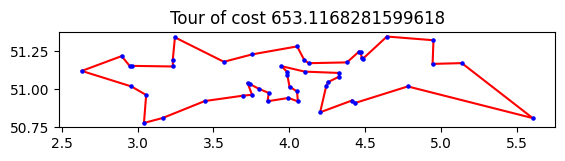

In [31]:
from itertools import groupby
from sklearn.metrics.pairwise import haversine_distances
# Create an instance of TSPSMA with the subset
tsp_sma = TSPSMA(cities=subset, tolerance = 1e-24, max_epochs_without_improvement = 100, pop_size = 200)

# Train the model
best_tour, best_fit, loss_train, keeper = tsp_sma.train()

# Print the best tour and its total distance
print("Best tour:", best_tour)
print("Total distance:", best_fit)


fig, ax = plt.subplots()
plot_cities(ax, subset)
plot_tour(ax, best_tour, subset, best_fit)
plt.show()

We applied this algorithm to a higher subset of the data, 400 random frituren to be exact.

> Epoch: 1, Best fit: 23405.42905153018
Best fit in kms: 23405.42905153018
> Epoch: 2, Best fit: 23225.13342322392
Best fit in kms: 23225.13342322392
> Epoch: 3, Best fit: 23024.425068043936
Best fit in kms: 23024.425068043936
> Epoch: 4, Best fit: 22634.759745576932
Best fit in kms: 22634.759745576932
> Epoch: 5, Best fit: 22401.751292597397
Best fit in kms: 22401.751292597397
> Epoch: 6, Best fit: 22111.652501563825
Best fit in kms: 22111.652501563825
> Epoch: 7, Best fit: 21557.588572756827
Best fit in kms: 21557.588572756827
> Epoch: 8, Best fit: 21479.887278608658
Best fit in kms: 21479.887278608658
> Epoch: 9, Best fit: 21330.479040819053
Best fit in kms: 21330.479040819053
> Epoch: 10, Best fit: 21020.97204674315
Best fit in kms: 21020.97204674315
> Epoch: 11, Best fit: 20718.521308626165
Best fit in kms: 20718.521308626165
> Epoch: 12, Best fit: 20622.444325676388
Best fit in kms: 20622.444325676388
> Epoch: 13, Best fit: 20609.294293935753
Best fit in kms: 20609.294293935753
>

IndexError: index 52 is out of bounds for axis 0 with size 50

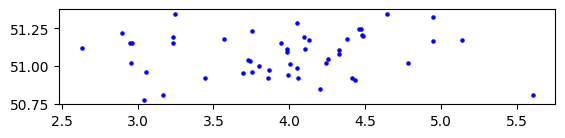

In [34]:
# Take a random subset of the coordinates
subset_size = 400  # Specify the size of the subset
subset_400 = random.sample(list(coordinates), subset_size)

# Convert the subset to a numpy array
subset_400 = np.array(subset_400)

# Create an instance of TSPSMA with the subset
tsp_sma = TSPSMA(cities=subset_400, tolerance = 1e-24, max_epochs_without_improvement = 100, pop_size = 500)

# Train the model
best_tour, best_fit, loss_train, keeper = tsp_sma.train()

# Print the best tour and its total distance
print("Best tour:", best_tour)
print("Total distance:", best_fit)


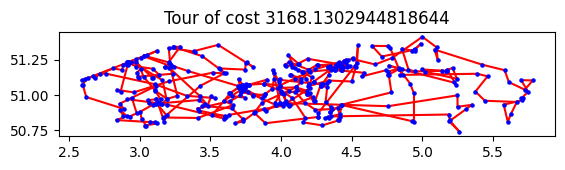

In [37]:
subset_400 = np.array(subset_400)

fig, ax = plt.subplots()
plot_cities(ax, subset_400)
plot_tour(ax, best_tour, subset_400, best_fit)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_9698/3312033380.py:67: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker2.set_data(frame, loss[frame])


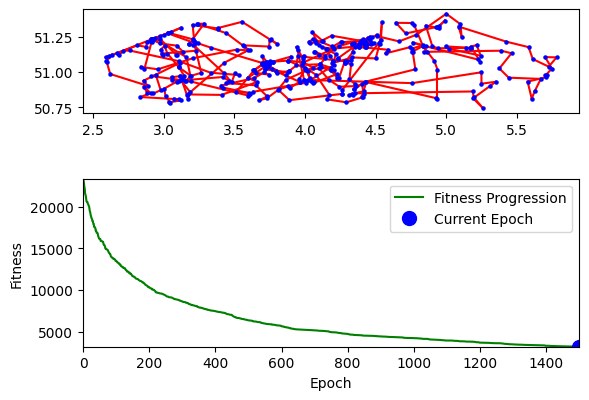

In [41]:
animationTSP(keeper, subset_400, 'fig/TSPSMA400.gif', interval = 75)

In [79]:
Image(filename='fig/TTSPSMA400.gif')

FileNotFoundError: [Errno 2] No such file or directory: 'fig/TTSPSMA400.gif'

We can see that it the algorithm cut off due to the maximum total epochs, given the plot above, it still had much room to improve.

## Comparison to simulated annealing

In [43]:
def elementary_random_swap(tour):
    """
    This function performs an elementary random swap operation on a tour.
    It randomly selects two cities and swaps their positions in the tour.

    Input:
    - tour: A list of city indices representing the tour.

    Output:
    - new_tour: A new tour obtained by swapping two cities in the input tour.
    """
    new_tour = tour.copy()
    i,j = random.sample(tour, 2)
    new_tour[i], new_tour[j] =  tour.copy()[j] , tour.copy()[i]       # Swapping the positions of two cities in the tour
    return new_tour 

def Simulated_Annealing_TSP(compute_tour_cost, tour0, distances, hyperparameters):
    """
    This function applies the Simulated Annealing algorithm to solve the Traveling Salesman Problem.

    Inputs:
    - compute_tour_cost: A function that computes the cost of a tour.
    - tour0: The initial tour.
    - distances: A 2D numpy array representing the distance between each pair of cities.
    - hyperparameters: A dictionary containing the hyperparameters for the algorithm.

    Outputs:
    - tour_star: The best tour found by the algorithm.
    - tour_path: A list of tours representing the path taken by the algorithm.
    - fbest: A list of the best cost found at each iteration.
    - temperatures: A list of the temperature at each iteration.
    """
    # get hyperparameters
    Tmax = hyperparameters['Tmax']  # Maximum (starting) temperature
    Tmin = hyperparameters['Tmin']  # Minimum (stopping) temperature
    r = hyperparameters['r']  # Rate of cooling
    N_it = hyperparameters['N_iterations']  # Number of iterations at each temperature

    # init outputs
    temp = Tmax  # Current temperature
    tour_star = tour0.copy()  # Current best tour
    tour_path = [tour0.copy()]  # List of tours taken
    fbest = [compute_tour_cost(tour0, distances)]  # List of best costs
    temperatures = [temp]  # List of temperatures
    fstar = compute_tour_cost(tour_star, distances)  # Current best cost

    while temp> Tmin:  # While the current temperature is greater than the minimum temperature
        for _ in range(N_it):  # For each iteration at the current temperature
            new_tour = elementary_random_swap(tour_star)  # Generate a new tour by randomly swapping two cities in the current best tour
            fnew =  compute_tour_cost(new_tour, distances)  # Compute the cost of the new tour
            if np.exp((fstar-fnew)/temp)  > np.random.rand():  # If the new tour is better than the current best tour, or if the algorithm decides to explore a worse solution
                tour_star=new_tour.copy()  # Update the current best tour to the new tour
                fstar=fnew  # Update the current best cost to the cost of the new tour
        tour_path.append(tour_star.copy())  # Add the current best tour to the list of tours taken
        fbest.append(fstar.copy())  # Add the current best cost to the list of best costs
        temp *=r  # Decrease the temperature
        temperatures.append(temp)  # Add the current temperature to the list of temperatures
    return tour_star, tour_path, fbest, temperatures  # Return the best tour found, the list of tours

In [44]:
hyperparameters = {'Tmax' : 100, 'Tmin' : 0.005, 'r' : 0.96, 'N_iterations' : 1000}
    
def compute_tour_cost(tour, distances):
    """
    Computes the total cost of a tour of the TSP. Optionally provides a
    sanity check to see of the tour is a correct solution.

    Input:
        - tour : list of n integers from 1 to n describing the order of the tour
                    (invariant under cyclic permunations)
        - distances : n x n distance matrix
        - check : boolean, check if a valid tour, default False

    Ouput:
        - tour_cost : cost of the tour
    """
    tour_cost = np.sum(distances[tour[:-1], tour[1:]])                     #complete   ( connect all cities, except the first and the last)
    tour_cost += distances[tour[-1], tour[0]]                                 #complete (connect the fist and the last city)
    return tour_cost

In [45]:
import itertools as it

def yield_some_permutations(tour, mtry):
    """
    Yields mtry permutations of a tour.
    """
    count = 0
    for perm in it.permutations(tour)  :                   #complete
        yield list(perm)
        count += 1
        if count > mtry:
            break
            
# determine min tour cost, starting from tour with index first city to index last city, for all permutations            
def lazy_brute_force(distances, mtry=1000):
    n, _ = distances.shape
    return min(yield_some_permutations(list(range(n)), mtry), key=lambda t : compute_tour_cost(t, distances))

dist_matrix = distance_matrix(subset[::-1], subset[::-1])
tour0 = lazy_brute_force(dist_matrix, mtry=100)

In [46]:
def plot_cities(ax, coordinates, color="blue"):
    """
    Plots the cities on a given axis.

    Inputs:
        - ax : the ax to plot on
        - coordinates : the coordinates of the cities
        - color : color of the cities (default blue)
    """
    p = ax.scatter(coordinates[:,1], coordinates[:,0], color=color, s=5, zorder=2)
    ax.set_aspect('equal')
    return p
def plot_tour(ax, tour, coordinates, distances, color="red", title=True):
    """
    Draws a tour on a given axis.

    Inputs:
        - ax : the ax to plot on
        - tour : a tour a list of indices
        - coordinates : the coordinates of the cities
        - distances : the matrix with distances
        - color : color of the tour (default red)
        - title : boolean, plot the title with cost?
    """
    for i, j in zip(tour[1:], tour[:-1]):
         xi, yi = coordinates[i,:]
         xj, yj = coordinates[j,:]
         ax.plot([yi, yj], [xi, xj], color=color, zorder=1)
            
            
    i, j = tour[-1], tour[0]
    xi, yi = coordinates[i,:]
    xj, yj = coordinates[j,:]

    p=ax.plot([yi, yj],[xi, xj], color=color, zorder=1)
       
    if title:
        ax.set_title('Tour of cost {:.2f}'.format(compute_tour_cost(tour,
                                                                distances)))
    
    return p

A run of SA on the subset of 50 frituren

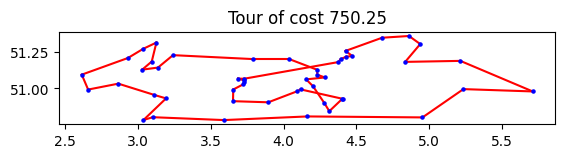

In [448]:
dist_matrix = haversine_distances([np.radians(coord) for coord in subset[::-1]])*6371.0
_best_tour, _tour_path, _best_tour_cost, _temperatures = Simulated_Annealing_TSP(compute_tour_cost, tour0, dist_matrix, hyperparameters)   #complete


fig, ax = plt.subplots()
plot_cities(ax, subset[::-1])
plot_tour(ax, _best_tour, subset[::-1], dist_matrix)
plt.show()

A run of SA on the subset of 50 frituren

/tmp/ipykernel_9698/3709663926.py:51: RuntimeWarning: overflow encountered in exp
  if np.exp((fstar-fnew)/temp)  > np.random.rand():  # If the new tour is better than the current best tour, or if the algorithm decides to explore a worse solution


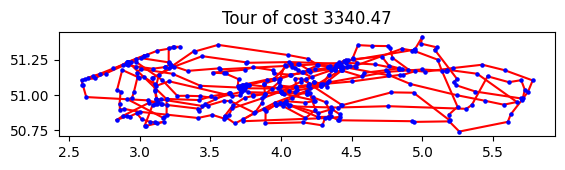

In [52]:
dist_matrix_400 = distance_matrix(subset_400[::-1], subset_400[::-1])
tour0 = lazy_brute_force(dist_matrix_400, mtry=100)
dist_matrix_400 = haversine_distances([np.radians(coord) for coord in subset_400[::-1]])*6371.0
hyperparameters = {'Tmax' : 100, 'Tmin' : 0.005, 'r' : 0.96, 'N_iterations' : 1500}
_best_tour, _tour_path, _best_tour_cost, _temperatures = Simulated_Annealing_TSP(compute_tour_cost, tour0, dist_matrix_400, hyperparameters)   #complete


fig, ax = plt.subplots()
plot_cities(ax, subset_400[::-1])
plot_tour(ax, _best_tour, subset_400[::-1], dist_matrix_400)
plt.show()

Even though it seems harder for the SA to converge to a globally optimal solution, it is much faster.

## Bayesian Optimization of the hyperparameters of our most optimal SMA TSP algorithm

Here we will apply Bayesion optimization to the SMA TSP algorithm using the `bayesian-optimization` package. For the theoretical background of Bayesian Optimization, we refer to the course notes.

In [78]:
from bayes_opt import BayesianOptimization

# Define the function to optimize
def optimize_func(max_epochs_without_improvement, pop_size):
    max_epochs_without_improvement = int(max_epochs_without_improvement)
    pop_size = int(pop_size)
    tsp_sma = TSPSMA(cities=subset, epoch=2000, max_epochs_without_improvement=max_epochs_without_improvement, pop_size=pop_size, verbose = False)
    best_tour, best_fit, loss_train, keeper = tsp_sma.train()
    return -best_fit  # We return the negative of best_fit because we want to maximize it

# Define the bounds of the parameters to optimize
bounds = {
    "max_epochs_without_improvement": (20, 125),
    "pop_size": (100, 1000)
}

# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize_func, pbounds=bounds, random_state=1)

# Perform the optimization
optimizer.maximize(init_points=2, n_iter=30)

# Print the best parameters found
print("Best parameters found: ")
print(optimizer.max['params'])


|   iter    |  target   | max_ep... | pop_size  |
-------------------------------------------------
Convergence reached after 263 epochs.
| 1         | -672.7    | 63.79     | 748.3     |
Convergence reached after 181 epochs.
| 2         | -718.1    | 20.01     | 372.1     |
Convergence reached after 186 epochs.
| 3         | -729.3    | 63.25     | 746.9     |
Convergence reached after 438 epochs.
| 4         | -676.0    | 107.2     | 694.1     |
Convergence reached after 177 epochs.
| 5         | -642.9    | 35.68     | 665.9     |
Convergence reached after 179 epochs.
| 6         | -653.1    | 29.04     | 782.8     |
Convergence reached after 254 epochs.
| 7         | -665.2    | 61.54     | 245.3     |
Convergence reached after 377 epochs.
| 8         | -705.0    | 113.2     | 502.5     |
Convergence reached after 277 epochs.
| 9         | -734.7    | 65.39     | 416.8     |
Convergence reached after 318 epochs.
| 10        | -688.9    | 84.04     | 453.6     |
Convergence reached 

Our application of Bayesian Optimization to fine-tune the SMA TSP algorithm has produced the following results:
```
Best parameters found: 
{'max_epochs_without_improvement': 35.6772048832416, 'pop_size': 665.9305876024864}
```
Of course, as these parameters are given as integers, we expect the algorithm to be optimal at `max_epochs_without_improvement` = 36 and `pop_size` = 666. It's important to bear in mind that these findings aren't definitive, as the progression of the algorithm is significantly influenced by factors such as initialization and inherent stochasticity. However, these results provide a valuable guide, suggesting a potentially effective region within the hyperparameter space when dealing with a problem involving 50 cities.